<a href="https://colab.research.google.com/github/VP-CAST/V2I-V2L/blob/main/EV_prediction_June_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains the EDA, data processing, and model building ideas for project **CO2 Emissions by Cars** which can be accessed at : [GitHub](https://github.com/d0r1h/CO2-Emission-by-Cars)

[Dataset](https://www.kaggle.com/datasets/debajyotipodder/co2-emission-by-vehicles) captures the details of how CO2 emissions by a vehicle can vary with the different features. The dataset has been taken from Canada Government official open data website.

In [ ]:
!pip install mlxtend -qq

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels
from scipy import stats
import statsmodels.api as sm
from scipy.stats import shapiro
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import Lasso, Ridge, ElasticNet, SGDRegressor, LinearRegression
from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV, cross_val_score, train_test_split

%matplotlib inline

from warnings import filterwarnings
filterwarnings('ignore')

# 2. Set Options <a id='set_options'></a>

In [ ]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.float_format = '{:.6f}'.format

# 3. Read Data <a id='Read_Data'></a>

In [ ]:
# loading sample dataset from pycaret dataset module
#from pycaret.datasets import get_data
#data = get_data('diabetes')
from google.colab import files
uploaded = files.upload()

Saving EV predication2.csv to EV predication2 (1).csv


In [ ]:

import io
import chardet

# Read the uploaded CSV file and detect the encoding
with open('EV predication2 (1).csv', 'rb') as f:
    result = chardet.detect(f.read())

# Print the detected encoding
print(result['encoding'])

# Read the CSV file with the detected encoding
data = pd.read_csv(io.BytesIO(uploaded['EV predication2 (1).csv']), encoding=result['encoding'])
#print(data)


data.head()
print(data.columns)

ascii
Index(['Model year', 'Make', 'Model', 'Vehicle class', 'Motor (kW)',
       'City (kWh/100 km)', 'Highway (kWh/100 km)', 'Combined (kWh/100 km)',
       'City (Le/100 km)', 'Highway (Le/100 km)', 'Combined (Le/100 km)',
       'Range (km)', 'Recharge time (h)'],
      dtype='object')


# 4. Exploratory Data Analysis <a id='data_preparation'></a>

## 4.1 Preparing the Dataset <a id='Data_Preparing'></a>

**Renaming Columns**

In [ ]:
data = data.rename(columns={
    'Vehicle class': 'Vehicle_Class',
    'Motor (kW)': 'Motor',
    'City (kWh/100 km)': 'city_kwh',
    'Highway (kWh/100 km)': 'Highway_kwh',
    'Combined (kWh/100 km)': 'Comb_kwh',
    'City (Le/100 km)': 'City_Le',
    'Highway (Le/100 km)': 'Hwy_Le',
    'Combined (Le/100 km)': 'Comb_Le',
    'Range (km)': 'Range',
    'Recharge time (h)': 'Charge_time'
})

### 4.1.1 Data Dimensions <a id='Data_Shape'></a>

In [ ]:
data.shape
print(data.columns)

Index(['Model year', 'Make', 'Model', 'Vehicle_Class', 'Motor', 'city_kwh',
       'Highway_kwh', 'Comb_kwh', 'City_Le', 'Hwy_Le', 'Comb_Le', 'Range',
       'Charge_time'],
      dtype='object')


In this dataset we have 7384 records across 12 features

### 4.1.2 Data Types <a id='Data_Types'></a>

In [ ]:
data.dtypes


Model year         int64
Make              object
Model             object
Vehicle_Class     object
Motor              int64
city_kwh         float64
Highway_kwh      float64
Comb_kwh         float64
City_Le          float64
Hwy_Le           float64
Comb_Le          float64
Range              int64
Charge_time      float64
dtype: object

The dataset contains **5 object columns, 3 int column and 4 float columns**

### 4.1.3 Missing Values <a id='Missing_Values'></a>

In [ ]:
missing_value = pd.DataFrame({
    'Missing Value': data.isnull().sum(),
    'Percentage': (data.isnull().sum() / len(data))*100
})

In [ ]:
missing_value.sort_values(by='Percentage', ascending=False)

,Missing Value,Percentage
Model year,0,0.000000
Make,0,0.000000
Model,0,0.000000
Vehicle_Class,0,0.000000
Motor,0,0.000000
city_kwh,0,0.000000
Highway_kwh,0,0.000000
Comb_kwh,0,0.000000
City_Le,0,0.000000
Hwy_Le,0,0.000000


There are **no missing values** present in this dataset

### 4.1.4 Duplicate Data <a id='duplicate'></a>

In [ ]:
duplicate = data.duplicated().sum()
print('There are {} duplicated rows in the data'.format(duplicate))

There are 0 duplicated rows in the data


In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data.reset_index(inplace=True, drop=True)


Now, the dataset has **6281 records and 12 features with no missing and duplicate values**

## 4.2  Data Understanding <a id='Data_Understanding'></a>

### 4.2.1 Summary Statistics <a id='Summary_Statistics'></a>

In [ ]:
data.describe(include=np.number)

,Model year,Motor,city_kwh,Highway_kwh,Comb_kwh,City_Le,Hwy_Le,Comb_Le,Range,Charge_time
count,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000
mean,2021.545455,325.116244,21.571237,23.669001,22.523547,2.425484,2.656036,2.527273,425.834575,10.166542
std,2.844834,164.987177,4.822722,5.029978,4.793943,0.541907,0.559788,0.535419,134.206005,2.761120
min,2012.000000,35.000000,13.700000,14.900000,14.800000,1.500000,1.700000,1.700000,92.000000,3.000000
25%,2020.000000,202.500000,17.400000,20.500000,18.850000,2.000000,2.300000,2.100000,363.000000,8.000000
50%,2023.000000,300.000000,21.000000,22.500000,21.700000,2.400000,2.500000,2.400000,428.000000,10.000000
75%,2024.000000,418.000000,25.000000,26.050000,25.500000,2.800000,2.900000,2.900000,505.000000,12.000000
max,2024.000000,930.000000,43.800000,49.000000,45.900000,4.900000,5.500000,5.200000,837.000000,18.000000


1. The average amount of CO2 emitted from cars is 251 g/km
2. Atleast 4 Litres of fuel is consumed be it the car is on city roads or highway
3. About 75% of the cars have 6 or less cylinders
4. The amount of fuel consumed by cars on city roads is comparitvely greater than that of highway

In [ ]:
data.describe(include = object)


,Make,Model,Vehicle_Class
count,671,671,671
unique,32,372,9
top,Tesla,Bolt EV,Sport utility vehicle: Standard
freq,158,7,140


1. There are a total of 42 different car companies with 2053 different car models
2. Vehicles are divided into 16 different classes with SUV-Small vehicles frequenting the most
3. 4 different types of fuels used by cars have been identified and fuel X seems to be the most famous
4. Most of the cars have AS6 transmission

### 4.2.2 Correlation <a id='correlation'></a>

In [ ]:
data_num_features = data.select_dtypes(include=np.number)

print('The numerical columns in the dataset are: ',data_num_features.columns)


The numerical columns in the dataset are:  Index(['Model year', 'Motor', 'city_kwh', 'Highway_kwh', 'Comb_kwh', 'City_Le',
       'Hwy_Le', 'Comb_Le', 'Range', 'Charge_time'],
      dtype='object')


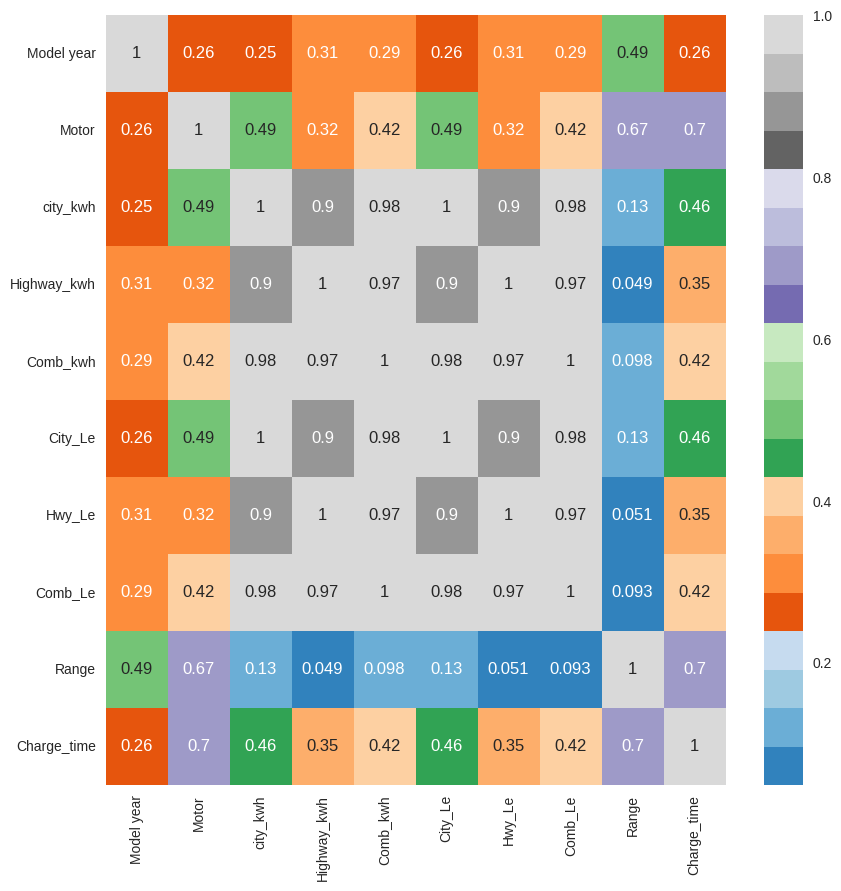

Index(['Model year', 'Make', 'Model', 'Vehicle_Class', 'Motor', 'city_kwh',
       'Highway_kwh', 'Comb_kwh', 'City_Le', 'Hwy_Le', 'Comb_Le', 'Range',
       'Charge_time'],
      dtype='object')


In [ ]:
features_to_include = data_num_features.columns

plt.figure(figsize=(10, 10))
corr = data_num_features[features_to_include].corr(method='pearson')
sns.heatmap(corr, annot=True, cmap='tab20c')
plt.show()
print(data.columns)

1. Fuel_Consumption_Comb1 has a high negative correaltion(<-0.9) with CO2_Emissions, Fuel_Consumption_Comb and Fuel_Consumption_City
2. CO2_Emissions has high positive correlation(>0.9) with Fuel_Consumption_Comb and Fuel_Consumption_City

### 4.2.3 Analyse Categorical Variables <a id='analyze_cat_var'></a>

1. Top 10 Make: Most of the cars on Canadian roads are made by Ford
2. Top 10 Model: The F-150 FFV is amongst the most famous models driven in Canada
3. Top 10 Vehicle_Class: SUV-Small is the preferred class of vehicle amongst the Canadians
4. Top 10 Transmission: More than 1000 cars have AS6 and AS8 transmission types
5. Fuel Type: Majority of the cars in Canada use Fuel type X and Z

### 4.2.4 Analyse Target Variable <a id='analyze_tar_var'></a>

From the above histogram, we can see that CO2_Emissions is moderately positive skewed

In [ ]:
mean = data['Range'].mean()
mode = data['Range'].mode()
median = data['Range'].median()

print(f'Mean for Range is {mean}')
print(f'Median for Range is {median}')
print(f'Mode for Range is {mode}')
print(data.columns)

Mean for Range is 425.8345752608048
Median for Range is 428.0
Mode for Range is 0    383
1    494
Name: Range, dtype: int64
Index(['Model year', 'Make', 'Model', 'Vehicle_Class', 'Motor', 'city_kwh',
       'Highway_kwh', 'Comb_kwh', 'City_Le', 'Hwy_Le', 'Comb_Le', 'Range',
       'Charge_time'],
      dtype='object')


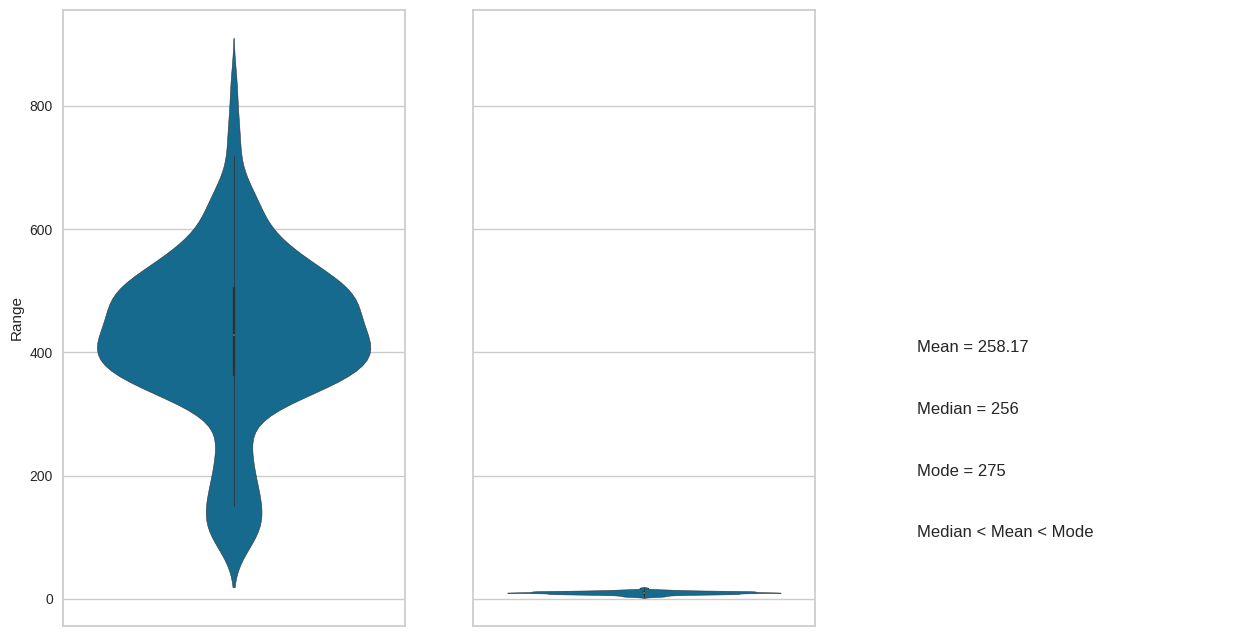

Index(['Model year', 'Make', 'Model', 'Vehicle_Class', 'Motor', 'city_kwh',
       'Highway_kwh', 'Comb_kwh', 'City_Le', 'Hwy_Le', 'Comb_Le', 'Range',
       'Charge_time'],
      dtype='object')


In [ ]:
fig, axes = plt.subplots(1,3, sharey=True, figsize=(15,8))
#sns.boxplot(y=data['Range'], orient="v", ax = axes[0])
sns.violinplot(y=data['Range'], orient="v", ax = axes[0]);
sns.violinplot(y=data['Charge_time'], orient="v", ax = axes[1]);
plt.text(0.1, 200, "Mode = 275", fontsize=12)
plt.text(0.1, 300, "Median = 256", fontsize=12)
plt.text(0.1, 400, "Mean = 258.17", fontsize=12)
plt.text(0.1, 100, "Median < Mean < Mode", fontsize=12)
plt.axis("off")
plt.show()
print(data.columns)

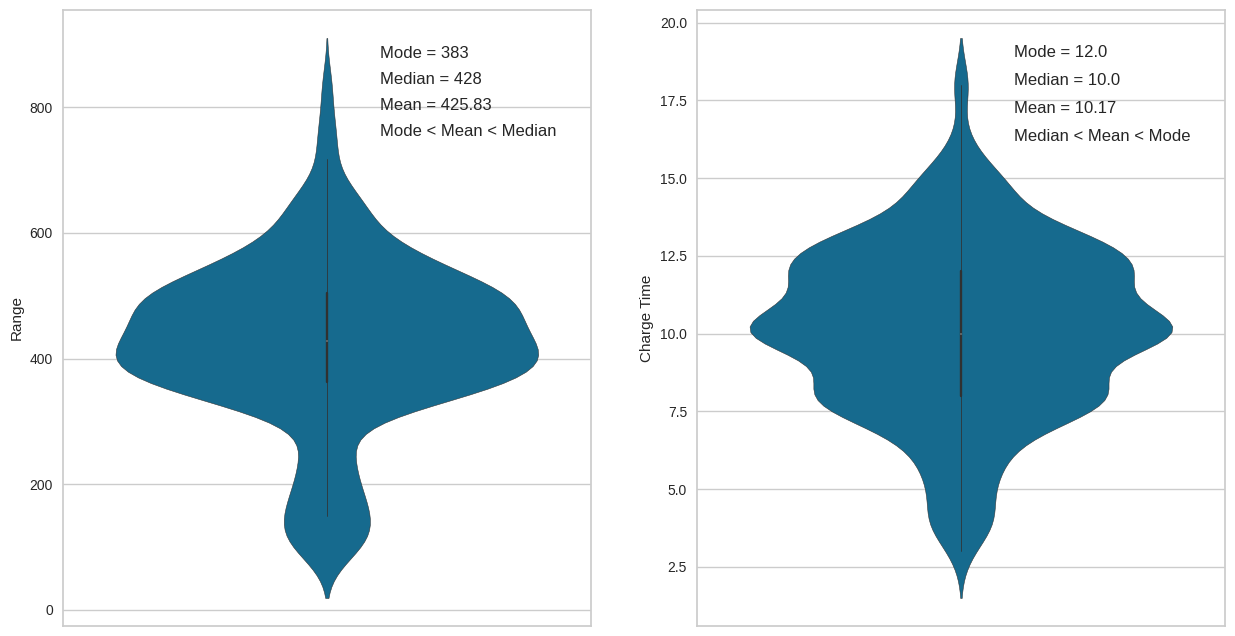

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statistics

# Assuming 'data' is your DataFrame

# Calculate statistics for Range
mode_range = statistics.mode(data['Range'])
median_range = statistics.median(data['Range'])
mean_range = statistics.mean(data['Range'])

# Calculate statistics for Charge Time
mode_charge_time = statistics.mode(data['Charge_time'])
median_charge_time = statistics.median(data['Charge_time'])
mean_charge_time = statistics.mean(data['Charge_time'])

# Determine the relationship between mode, median, and mean for Range
if median_range < mean_range < mode_range:
    relation_range = "Median < Mean < Mode"
elif mode_range < mean_range < median_range:
    relation_range = "Mode < Mean < Median"
elif mean_range < median_range < mode_range:
    relation_range = "Mean < Median < Mode"
else:
    relation_range = "No clear relationship"

# Determine the relationship between mode, median, and mean for Charge Time
if median_charge_time < mean_charge_time < mode_charge_time:
    relation_charge_time = "Median < Mean < Mode"
elif mode_charge_time < mean_charge_time < median_charge_time:
    relation_charge_time = "Mode < Mean < Median"
elif mean_charge_time < median_charge_time < mode_charge_time:
    relation_charge_time = "Mean < Median < Mode"
else:
    relation_charge_time = "No clear relationship"

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plotting Range with its own y-axis
sns.violinplot(y=data['Range'], orient="v", ax=axes[0])
axes[0].set_ylabel('Range')
# Place text annotations higher for Range
axes[0].text(0.1, 1.05 * max(data['Range']), f"Mode = {mode_range}", fontsize=12)
axes[0].text(0.1, 1.00 * max(data['Range']), f"Median = {median_range}", fontsize=12)
axes[0].text(0.1, 0.95 * max(data['Range']), f"Mean = {mean_range:.2f}", fontsize=12)
axes[0].text(0.1, 0.90 * max(data['Range']), relation_range, fontsize=12)

# Creating a secondary y-axis for Charge Time
sns.violinplot(y=data['Charge_time'], orient="v", ax=axes[1])
axes[1].set_ylabel('Charge Time')
# Place text annotations higher for Charge Time
axes[1].text(0.1, 1.05 * max(data['Charge_time']), f"Mode = {mode_charge_time}", fontsize=12)
axes[1].text(0.1, 1.00 * max(data['Charge_time']), f"Median = {median_charge_time}", fontsize=12)
axes[1].text(0.1, 0.95 * max(data['Charge_time']), f"Mean = {mean_charge_time:.2f}", fontsize=12)
axes[1].text(0.1, 0.90 * max(data['Charge_time']), relation_charge_time, fontsize=12)

plt.show()
#print(data.columns)


Of all the three statistics, the mean is the largest, while the mode is the smallest thus CO2_Emissions is positively skewed which implies that most of the CO2 Emissions are less than the average CO2 Emissions.

### 4.2.5 Analyse Relationship between Target and Independent Variables <a id='analyze_tar_ind_var'></a>

In [ ]:

make_range = data.groupby('Make')['Range'].mean().sort_values(ascending=False).head(10)
model_range = data.groupby('Model')['Range'].mean().sort_values(ascending=False).head(10)
vehicle_class_range = data.groupby('Vehicle_Class')['Range'].mean().sort_values(ascending=False).head(10)
make_charge = data.groupby('Make')['Charge_time'].mean().sort_values(ascending=False).head(10)
model_charge = data.groupby('Model')['Charge_time'].mean().sort_values(ascending=False).head(10)
vehicle_class_charge = data.groupby('Vehicle_Class')['Charge_time'].mean().sort_values(ascending=False).head(10)


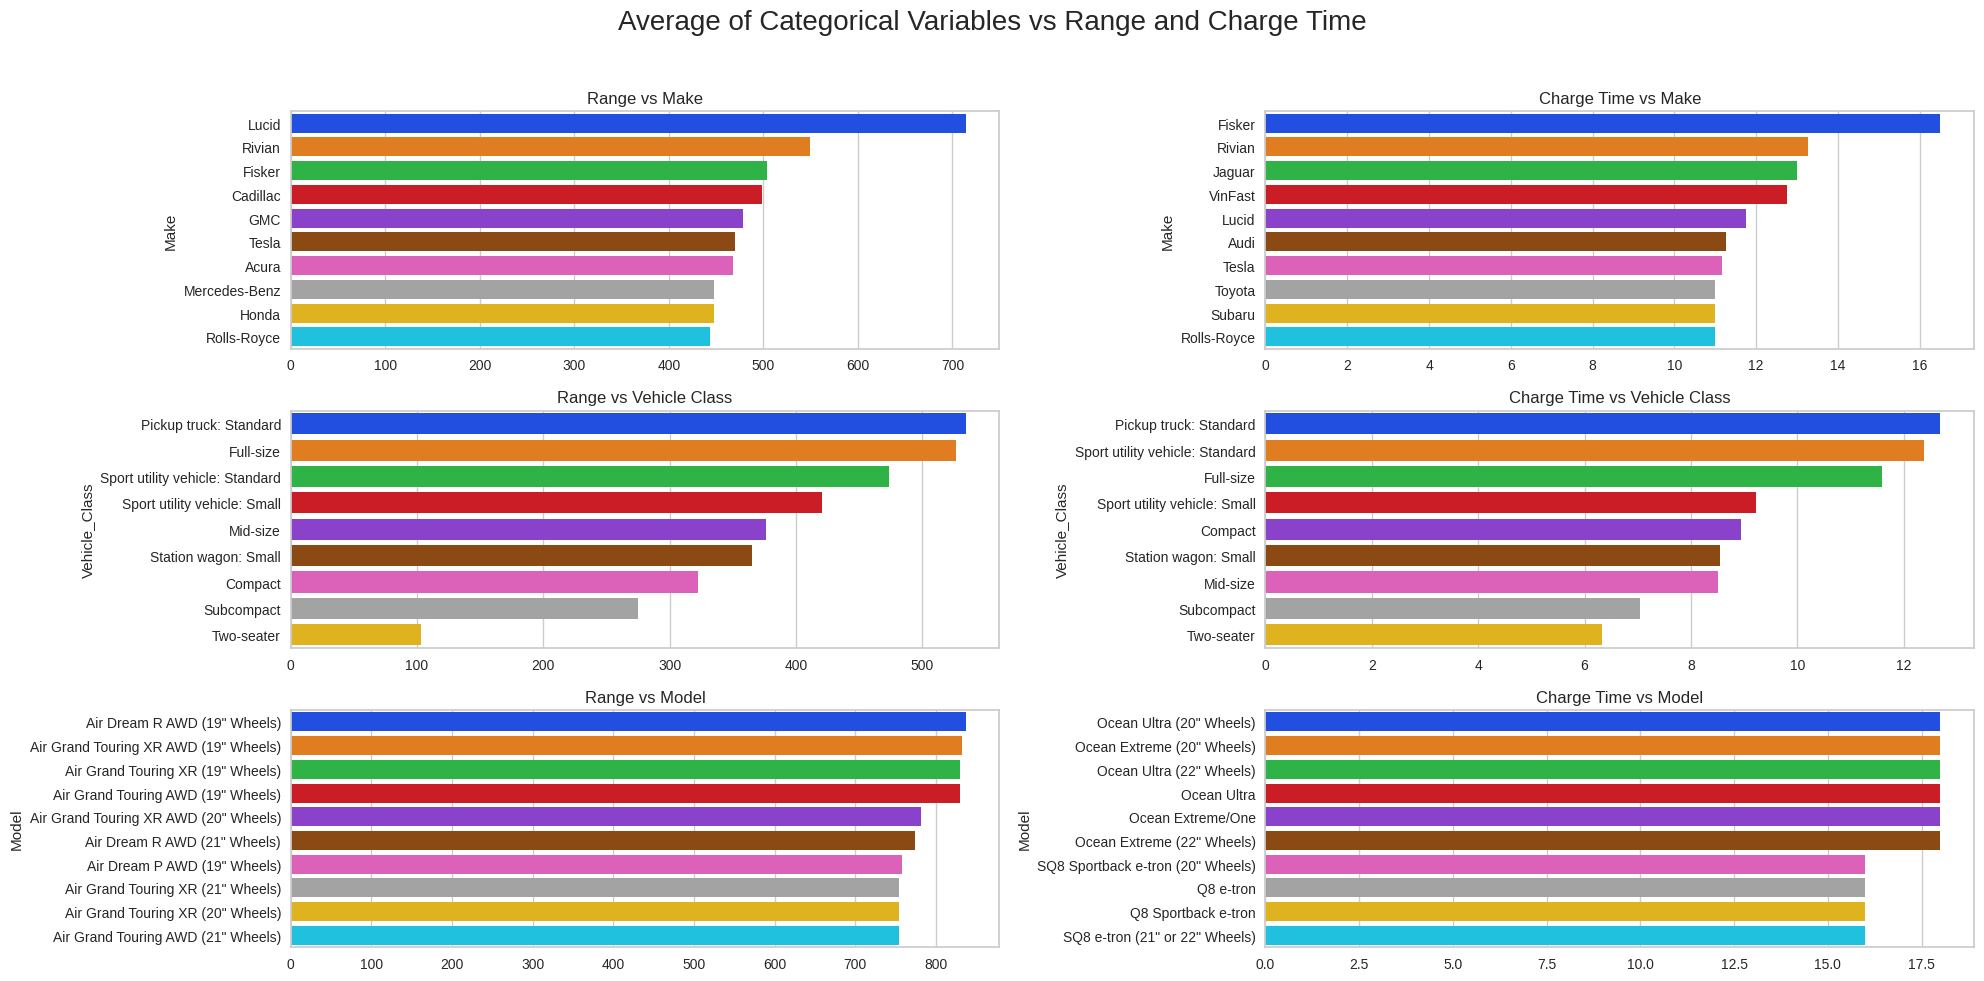

In [ ]:


fig, axes = plt.subplots(3, 2, figsize=(20, 10))
fig.suptitle('Average of Categorical Variables vs Range and Charge Time', size=20)

palette = sns.color_palette("bright", max(len(make_range), len(vehicle_class_range), len(model_range)))

# Range vs Make
sns.barplot(ax=axes[0][0], x=make_range.values, y=make_range.index, palette=palette)
axes[0][0].set_title('Range vs Make')

# Range vs Vehicle Class
sns.barplot(ax=axes[1][0], x=vehicle_class_range.values, y=vehicle_class_range.index, palette=palette)
axes[1][0].set_title('Range vs Vehicle Class')

# Range vs Model
sns.barplot(ax=axes[2][0], x=model_range.values, y=model_range.index, palette=palette)
axes[2][0].set_title('Range vs Model')

# Charge Time vs Make
sns.barplot(ax=axes[0][1], x=make_charge.values, y=make_charge.index, palette=palette)
axes[0][1].set_title('Charge Time vs Make')

# Charge Time vs Vehicle Class
sns.barplot(ax=axes[1][1], x=vehicle_class_charge.values, y=vehicle_class_charge.index, palette=palette)
axes[1][1].set_title('Charge Time vs Vehicle Class')

# Charge Time vs Model
sns.barplot(ax=axes[2][1], x=model_charge.values, y=model_charge.index, palette=palette)
axes[2][1].set_title('Charge Time vs Model')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()


1. CO2 Emissions v/s Make: While Ford cars are mainly found on the roads of Canada , its Bugatti that emit the most CO2 per car
2. CO2 Emissions v/s Model: Bugatti Chiron is amongst the most CO2 emitting car model
3. CO2 Emissions v/s Vehicle_Class: Most of the heavy vehicles like Vans , SUV and Pick-up truck are amongst the top few emitters of CO2
4. CO2 Emissions v/s Transmission: Most of the cars with automatic transmission emit CO2
5. CO2 Emissions v/s Fuel_Type: Cars using Fuel Type E are emitting the most CO2

**Relationship between Cylinders and CO2 Emissions**

From the above scatter plot we can see that:
1. As the number of cylinders increase, the CO2 emissions increase
2. Cars with 8 and less than 8 cylinders prefer using Fuel Type X which result in less emissions of CO2
3. Fuel Type Z results in more CO2 emissions than the other

In [ ]:
#plt.figure(figsize=(10,5))
#sns.pairplot(data,kind="reg")
#plt.show()

1. Fuel_Consumption_Comb1 shows a negative relation with all the other numerical variables
2. Fuel_Consumption_City and Fuel_Consumption_Hwy are strongly postively related

### 4.2.6 Feature Engineering <a id='feature_eng'></a>

In [ ]:
data['Make'].unique()
data['Make'] = data['Make'].str.upper()
data['Make'].unique()


array(['MITSUBISHI', 'NISSAN', 'FORD', 'SMART', 'TESLA', 'CHEVROLET',
       'BMW', 'KIA', 'HYUNDAI', 'VOLKSWAGEN', 'AUDI', 'JAGUAR',
       'SMART EQ', 'MINI', 'PORSCHE', 'POLESTAR', 'VOLVO', 'LUCID',
       'MAZDA', 'MERCEDES-BENZ', 'RIVIAN', 'CADILLAC', 'FISKER',
       'GENESIS', 'LEXUS', 'SUBARU', 'TOYOTA', 'VINFAST', 'ACURA', 'GMC',
       'HONDA', 'ROLLS-ROYCE'], dtype=object)

Create a new feature Make_Type by combining various car companies(Make) on the basis of their functionality
<br>
There are 42 unique Car Companies. We will divide these companies into Luxury, Sports, Premium and General cars

In [ ]:
data['Make_Type'] = data['Make'].replace(['BUGATTI', 'PORSCHE', 'MASERATI', 'ASTON MARTIN', 'LAMBORGHINI', 'JAGUAR', 'SRT', 'TESLA'], 'Sports')
data['Make_Type'] = data['Make_Type'].replace(['ALFA ROMEO', 'AUDI', 'BMW', 'BUICK', 'CADILLAC', 'CHRYSLER', 'DODGE', 'GMC', 'INFINITI', 'JEEP', 'LAND ROVER', 'LEXUS', 'MERCEDES-BENZ', 'MINI', 'SMART', 'VOLVO', 'POLESTAR', 'FISKER', 'RIVIAN'], 'Premium')
data['Make_Type'] = data['Make_Type'].replace(['ACURA', 'BENTLEY', 'LINCOLN', 'ROLLS-ROYCE', 'GENESIS', 'LUCID'], 'Luxury')
data['Make_Type'] = data['Make_Type'].replace(['CHEVROLET', 'FIAT', 'FORD', 'KIA', 'HONDA', 'HYUNDAI', 'MAZDA', 'MITSUBISHI', 'NISSAN', 'RAM', 'SCION', 'SUBARU', 'TOYOTA', 'VOLKSWAGEN', 'VINFAST', 'SMART EQ'], 'General')
data['Make_Type'].unique()
print(data.columns)



Index(['Model year', 'Make', 'Model', 'Vehicle_Class', 'Motor', 'city_kwh',
       'Highway_kwh', 'Comb_kwh', 'City_Le', 'Hwy_Le', 'Comb_Le', 'Range',
       'Charge_time', 'Make_Type'],
      dtype='object')


In [ ]:
#data.drop(['Make'], inplace=True, axis=1)

data['Vehicle_Class'].nunique()




9

In [ ]:
data['Make'].value_counts()


Make
TESLA            158
RIVIAN            66
BMW               60
FORD              43
KIA               35
AUDI              31
PORSCHE           30
MERCEDES-BENZ     28
HYUNDAI           27
NISSAN            27
LUCID             24
CHEVROLET         18
VOLKSWAGEN        17
POLESTAR          12
SMART             10
VOLVO              9
VINFAST            8
GENESIS            8
FISKER             8
CADILLAC           6
GMC                6
MITSUBISHI         6
MINI               5
JAGUAR             5
LEXUS              4
TOYOTA             4
ROLLS-ROYCE        4
MAZDA              3
HONDA              3
SUBARU             2
SMART EQ           2
ACURA              2
Name: count, dtype: int64

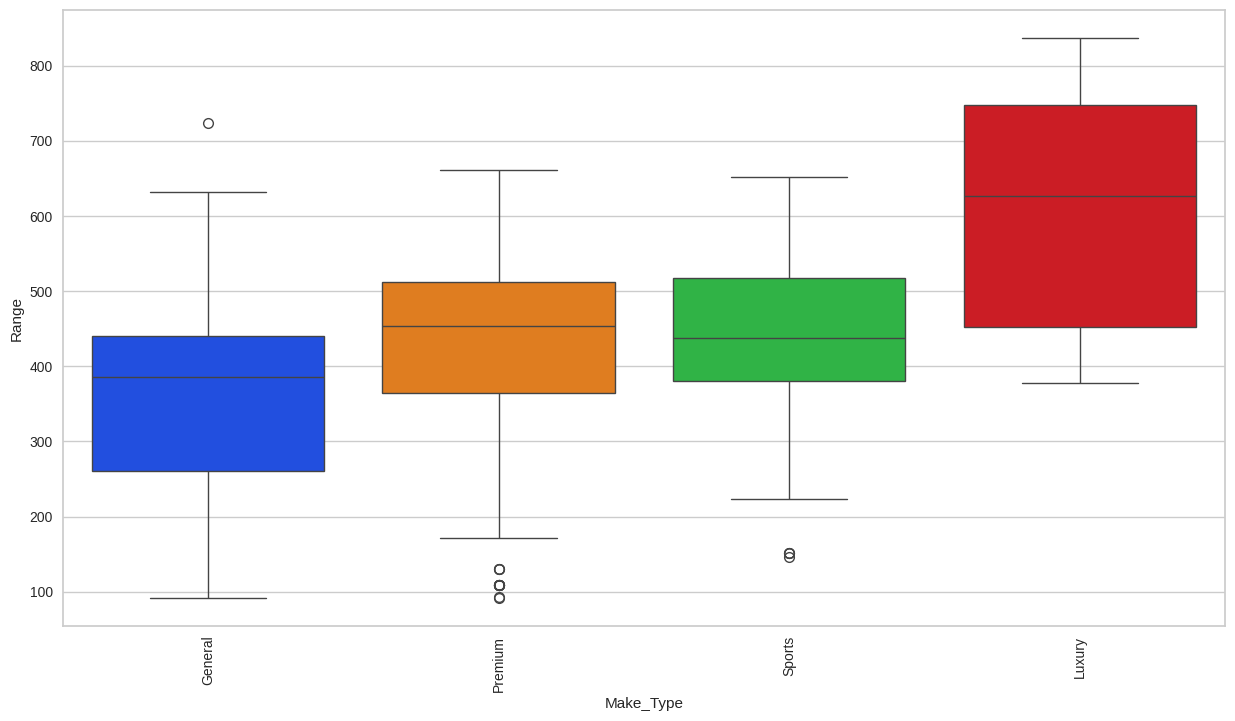

Index(['Model year', 'Make', 'Model', 'Vehicle_Class', 'Motor', 'city_kwh',
       'Highway_kwh', 'Comb_kwh', 'City_Le', 'Hwy_Le', 'Comb_Le', 'Range',
       'Charge_time', 'Make_Type'],
      dtype='object')


In [ ]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Make_Type", y="Range", data=data, palette='bright')  # 'Set3' is an example of a color palette
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()
print(data.columns)

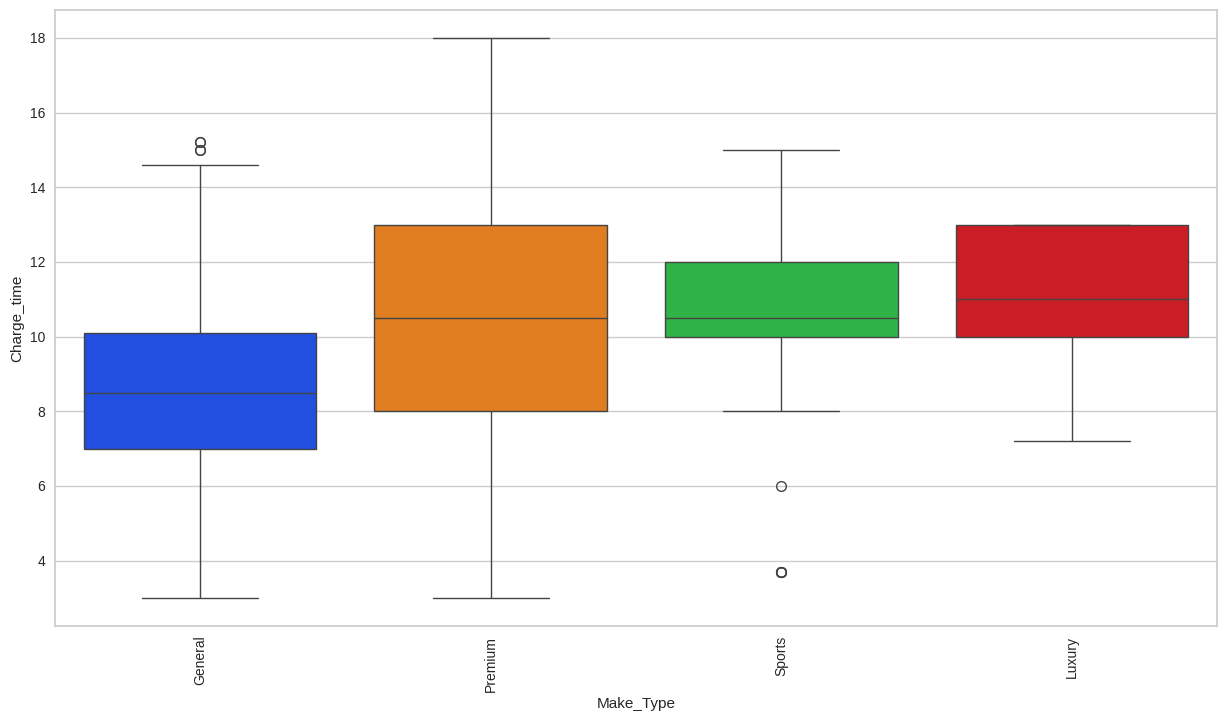

Index(['Model year', 'Make', 'Model', 'Vehicle_Class', 'Motor', 'city_kwh',
       'Highway_kwh', 'Comb_kwh', 'City_Le', 'Hwy_Le', 'Comb_Le', 'Range',
       'Charge_time', 'Make_Type'],
      dtype='object')


In [ ]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Make_Type", y="Charge_time", data=data, palette='bright')  # 'Set3' is an example of a color palette
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()
print(data.columns)

The plot shows that Sports cars and Luxury cars emit more CO2 compared to Premium and General use cars

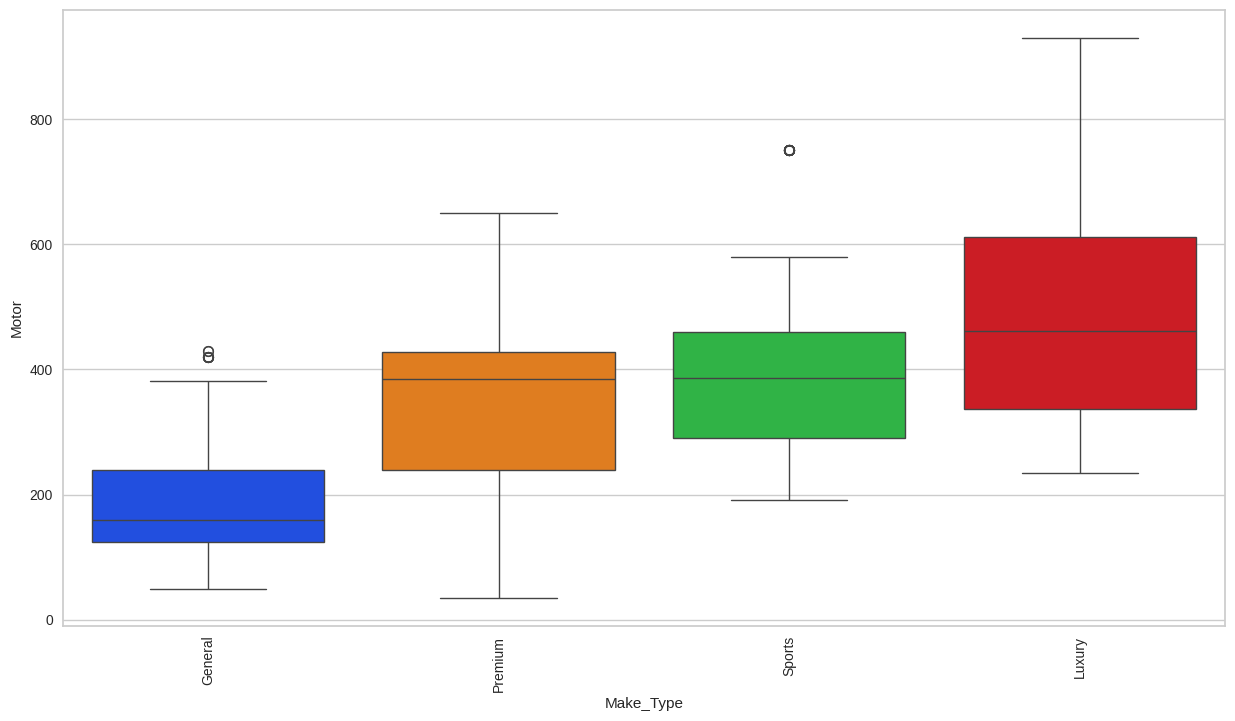

Index(['Model year', 'Make', 'Model', 'Vehicle_Class', 'Motor', 'city_kwh',
       'Highway_kwh', 'Comb_kwh', 'City_Le', 'Hwy_Le', 'Comb_Le', 'Range',
       'Charge_time', 'Make_Type'],
      dtype='object')


In [ ]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Make_Type", y="Motor", data=data, palette='bright')  # 'Set3' is an example of a color palette
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()
print(data.columns)

In [ ]:
data['Vehicle_Class'].unique()
data['Vehicle_Class'] = data['Vehicle_Class'].str.upper()
data['Vehicle_Class'].unique()

array(['SUBCOMPACT', 'MID-SIZE', 'COMPACT', 'TWO-SEATER', 'FULL-SIZE',
       'STATION WAGON: SMALL', 'SPORT UTILITY VEHICLE: STANDARD',
       'SPORT UTILITY VEHICLE: SMALL', 'PICKUP TRUCK: STANDARD'],
      dtype=object)

Create a new feature Vehicle_Class_Type by combining various Vehicle_Class on the basis of their size
<br>
There are 16 unique Vehicle Classes. We will divide them into Hatchback, Sedan, SUV and Truck

In [ ]:
data['Vehicle_Categories'] = data['Vehicle_Class'].replace(['COMPACT', 'MINICOMPACT', 'SUBCOMPACT'], 'Hatchback')
data['Vehicle_Categories'] = data['Vehicle_Categories'].replace(['MID-SIZE', 'TWO-SEATER', 'FULL-SIZE', 'STATION WAGON: SMALL', 'STATION WAGON: MID-SIZE'],'Sedan')
data['Vehicle_Categories'] = data['Vehicle_Categories'].replace(['SPORT UTILITY VEHICLE: SMALL', 'SPORT UTILITY VEHICLE: STANDARD', 'MINIVAN'],  'SUV')
data['Vehicle_Categories'] = data['Vehicle_Categories'].replace(['VAN - CARGO', 'VAN: PASSENGER', 'PICKUP TRUCK: STANDARD', 'SPECIAL PURPOSE VEHICLE', 'PICKUP TRUCK: SMALL'], 'Truck')


In [ ]:
print(data.columns)

Index(['Model year', 'Make', 'Model', 'Vehicle_Class', 'Motor', 'city_kwh',
       'Highway_kwh', 'Comb_kwh', 'City_Le', 'Hwy_Le', 'Comb_Le', 'Range',
       'Charge_time', 'Make_Type', 'Vehicle_Categories'],
      dtype='object')


In [ ]:
#data.drop(['Vehicle_Class'], inplace=True,  axis=1)

data['Vehicle_Categories'].unique()

array(['Hatchback', 'Sedan', 'SUV', 'Truck'], dtype=object)

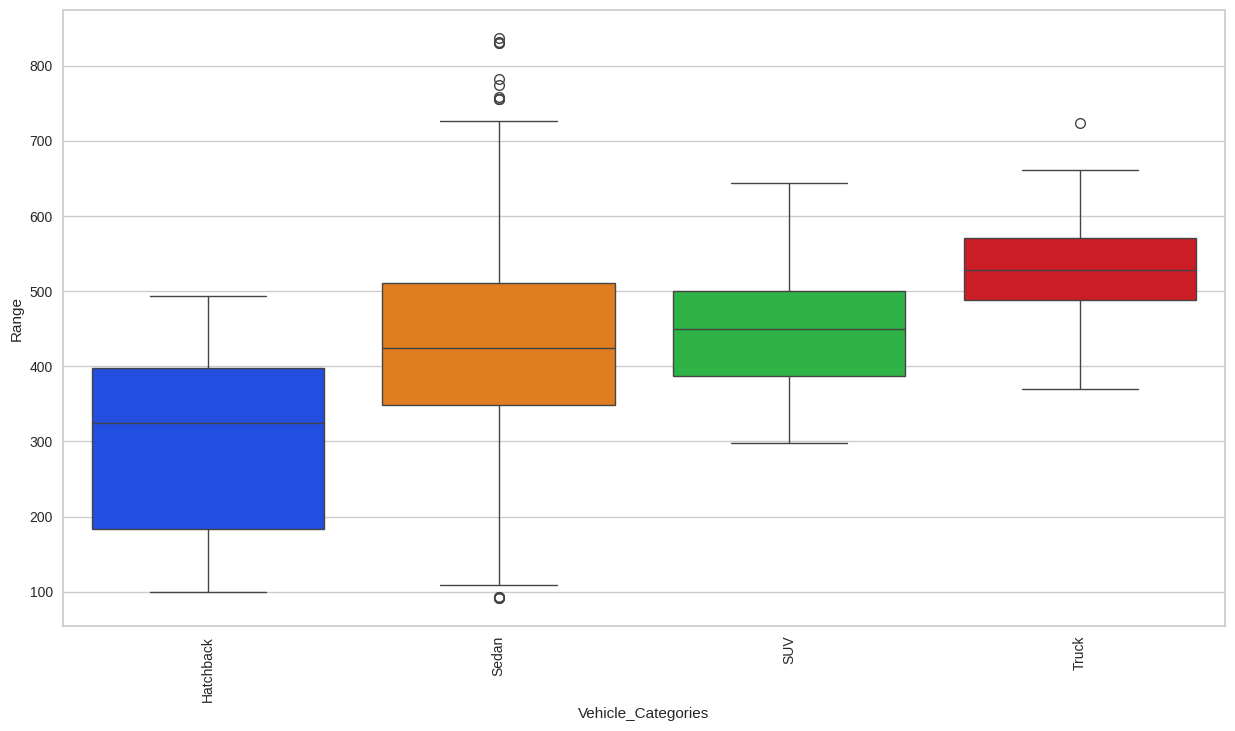

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Vehicle_Categories", y="Range", data=data, palette='bright')  # 'Set3' is an example of a color palette
ax.set_xticklabels(ax.get_xticklabels(), rotation=90  )
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
plt.show()

The plot shows that the bigger the cars are the more CO2 they emit

# 5. Data Preprocessing <a id='data_pre'></a>

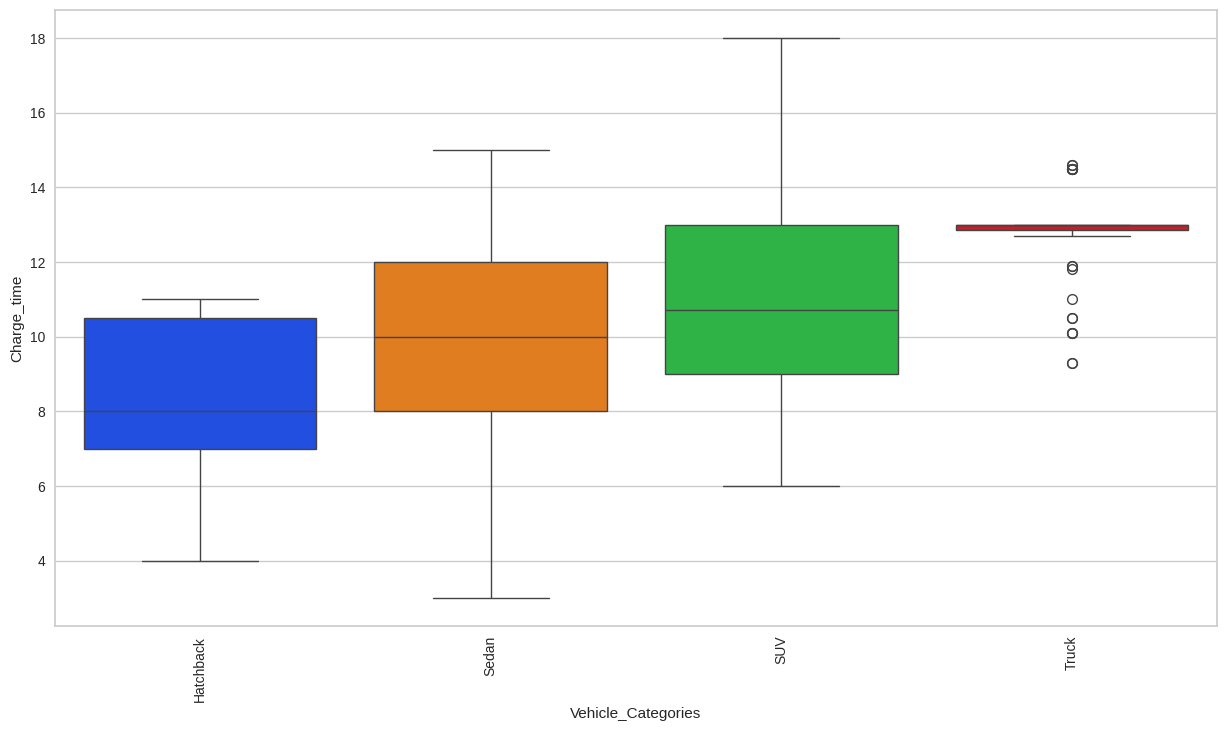

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Vehicle_Categories", y="Charge_time", data=data, palette='bright')  # 'Set3' is an example of a color palette
ax.set_xticklabels(ax.get_xticklabels(), rotation=90  )
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
plt.show()

In [ ]:
#data.drop(['Model'],axis=1,inplace=True)
print(data.columns)

Index(['Model year', 'Make', 'Model', 'Vehicle_Class', 'Motor', 'city_kwh',
       'Highway_kwh', 'Comb_kwh', 'City_Le', 'Hwy_Le', 'Comb_Le', 'Range',
       'Charge_time', 'Make_Type', 'Vehicle_Categories'],
      dtype='object')


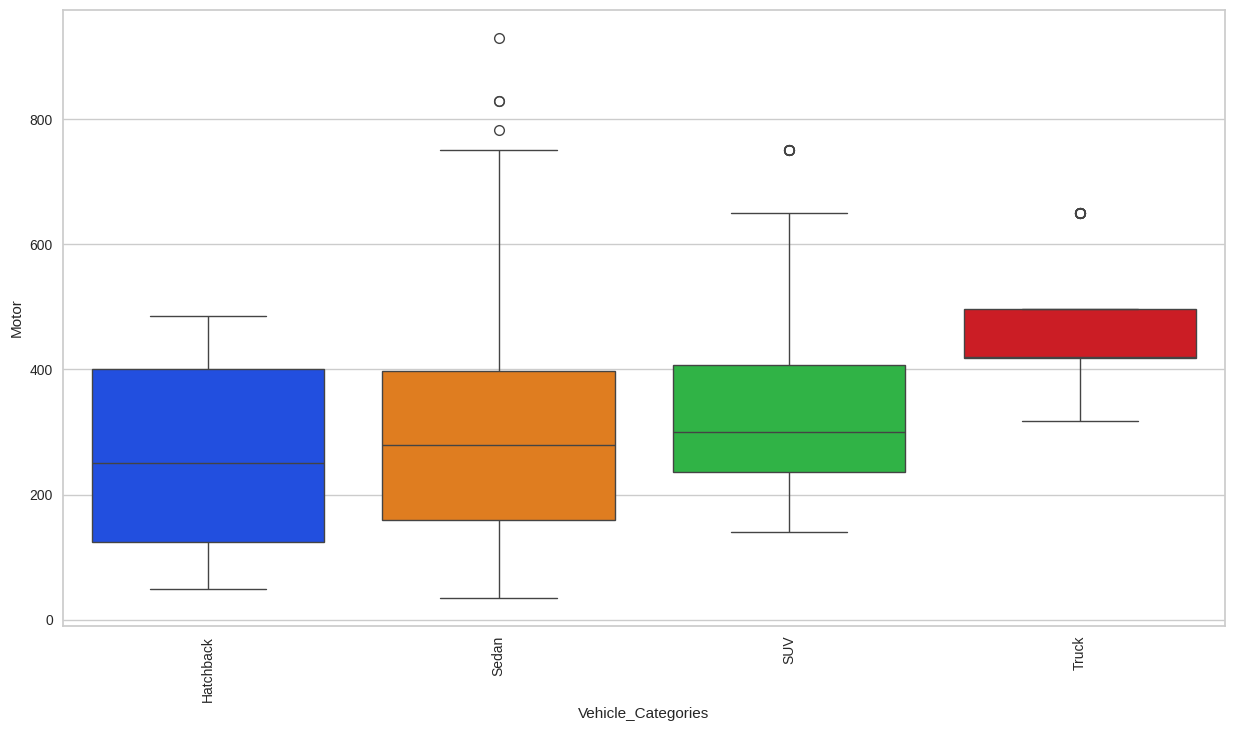

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Vehicle_Categories", y="Motor", data=data, palette='bright')  # 'Set3' is an example of a color palette
ax.set_xticklabels(ax.get_xticklabels(), rotation=90  )
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
plt.show()

Since Model has 2053 unique values and has no significance with respect to CO2 Emissions , we have dropped this column

## 5.1 Outliers <a id='out'></a>

### 5.1.1 Discovery of Outliers<a id='dis_out'></a>

In [ ]:
df_num_features=data.select_dtypes(include=np.number)


**Identifying outliers using IQR**

In [ ]:
Q1 = df_num_features.quantile(0.25)
Q3 = df_num_features.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Model year      4.000000
Motor         215.500000
city_kwh        7.600000
Highway_kwh     5.550000
Comb_kwh        6.650000
City_Le         0.800000
Hwy_Le          0.600000
Comb_Le         0.800000
Range         142.000000
Charge_time     4.000000
dtype: float64


In [ ]:
outlier = pd.DataFrame((df_num_features < (Q1 - 1.5 * IQR)) | (df_num_features > (Q3 + 1.5 * IQR)))

for i in outlier.columns:
    print('Total number of Outliers in column {} are {}'.format(i, (len(outlier[outlier[i] == True][i]))))

Total number of Outliers in column Model year are 11
Total number of Outliers in column Motor are 18
Total number of Outliers in column city_kwh are 6
Total number of Outliers in column Highway_kwh are 23
Total number of Outliers in column Comb_kwh are 8
Total number of Outliers in column City_Le are 8
Total number of Outliers in column Hwy_Le are 23
Total number of Outliers in column Comb_Le are 8
Total number of Outliers in column Range are 49
Total number of Outliers in column Charge_time are 0


**Visualizing outliers using Boxplots**

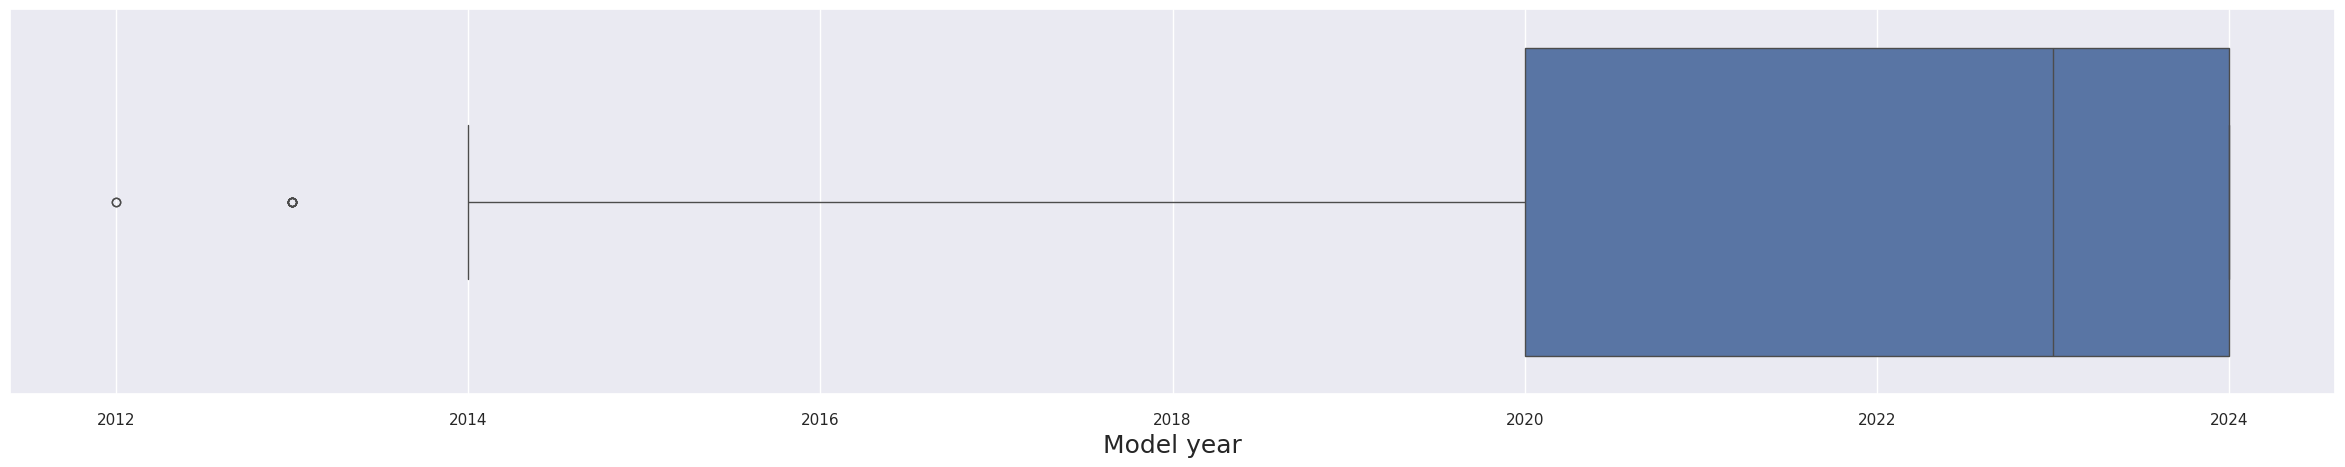

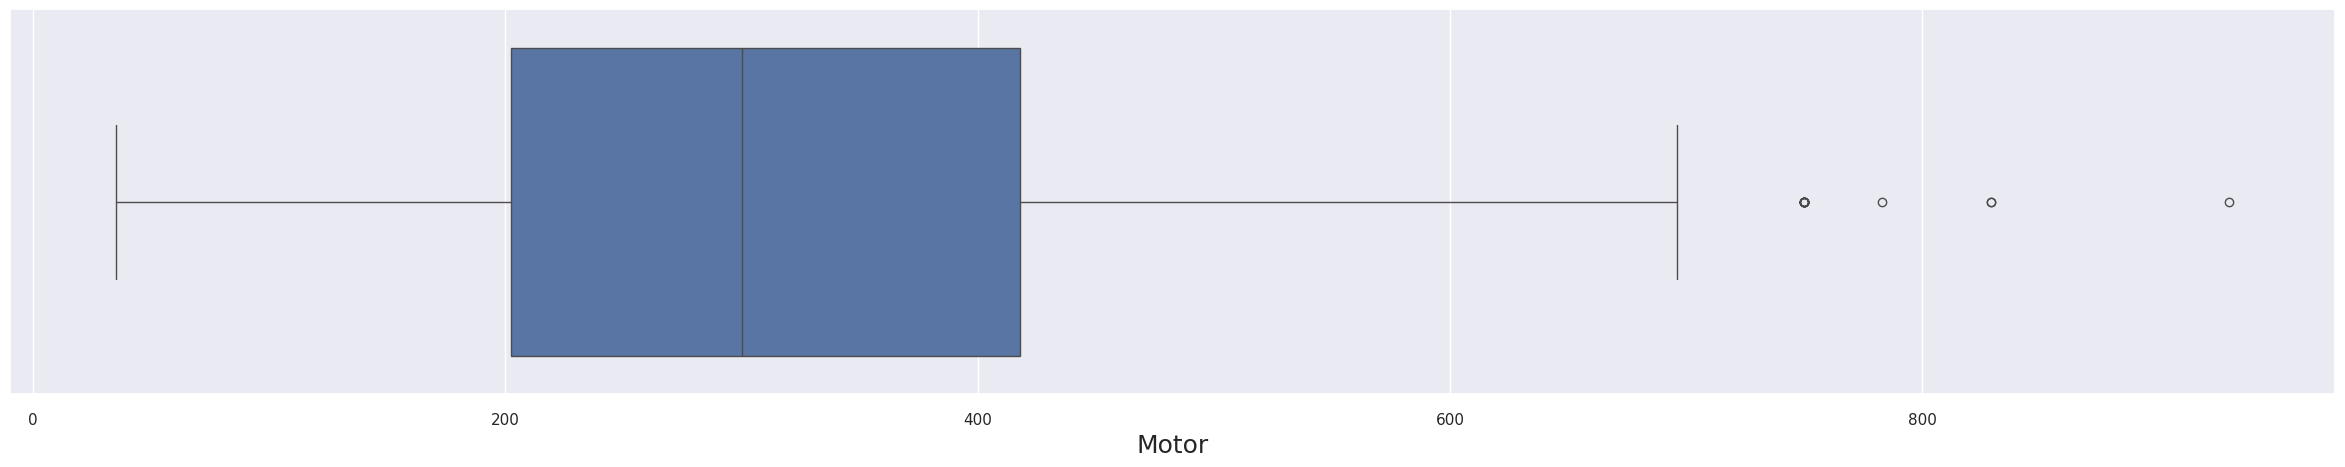

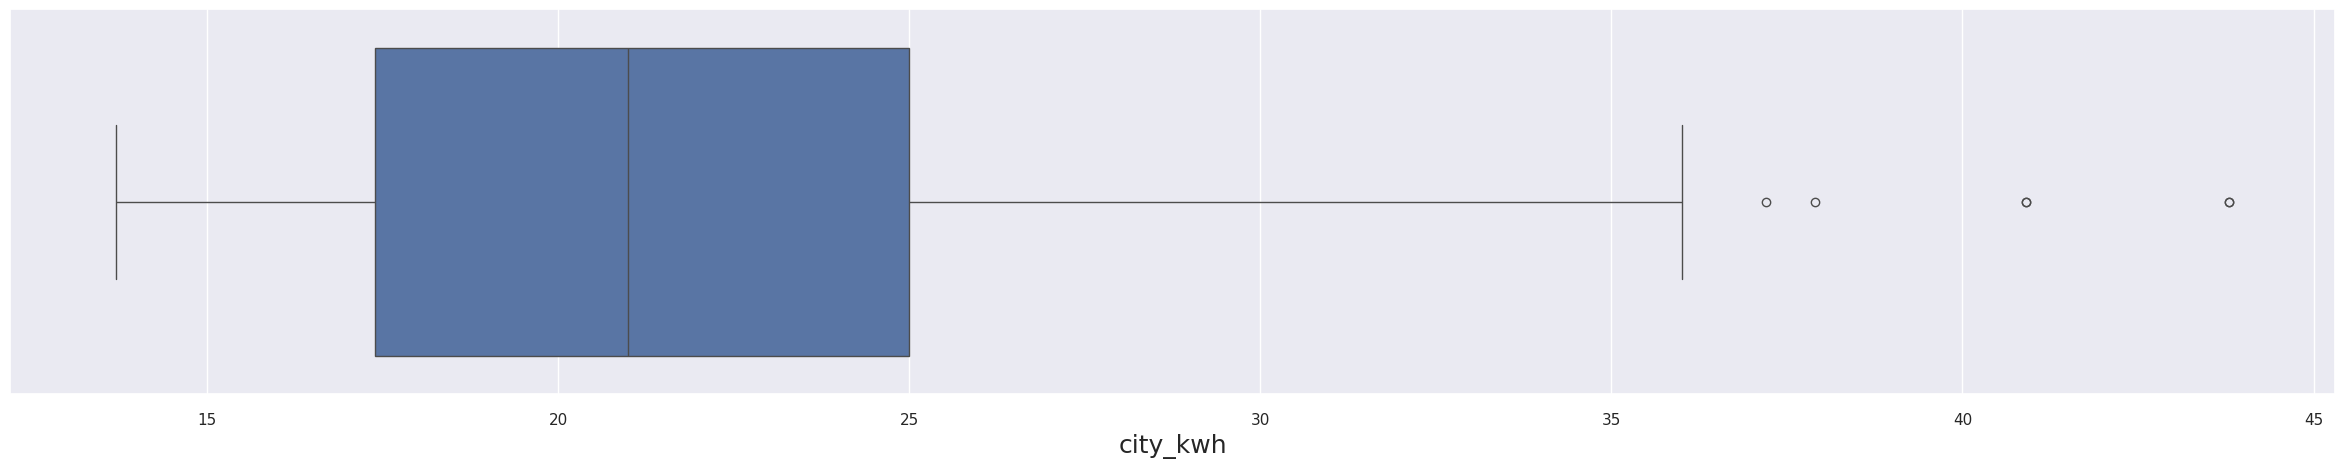

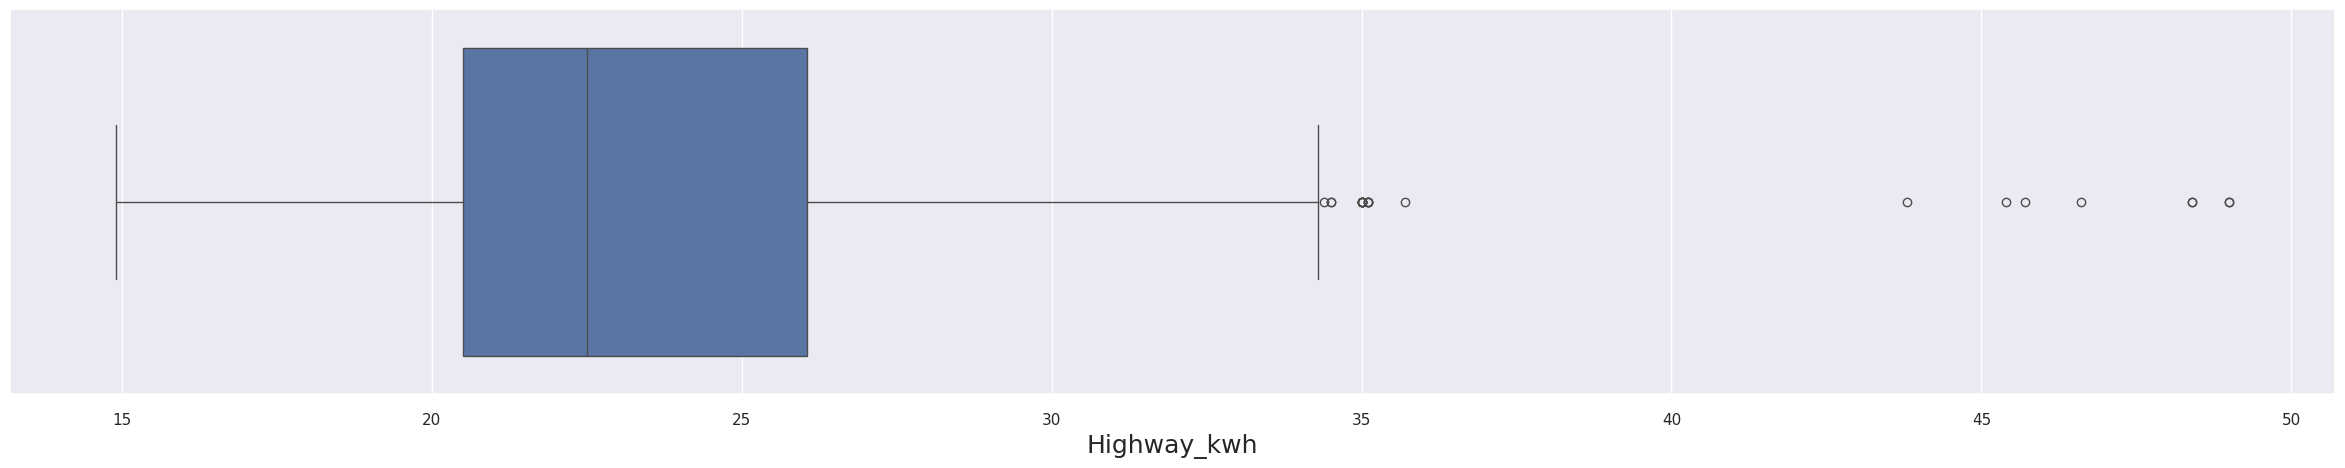

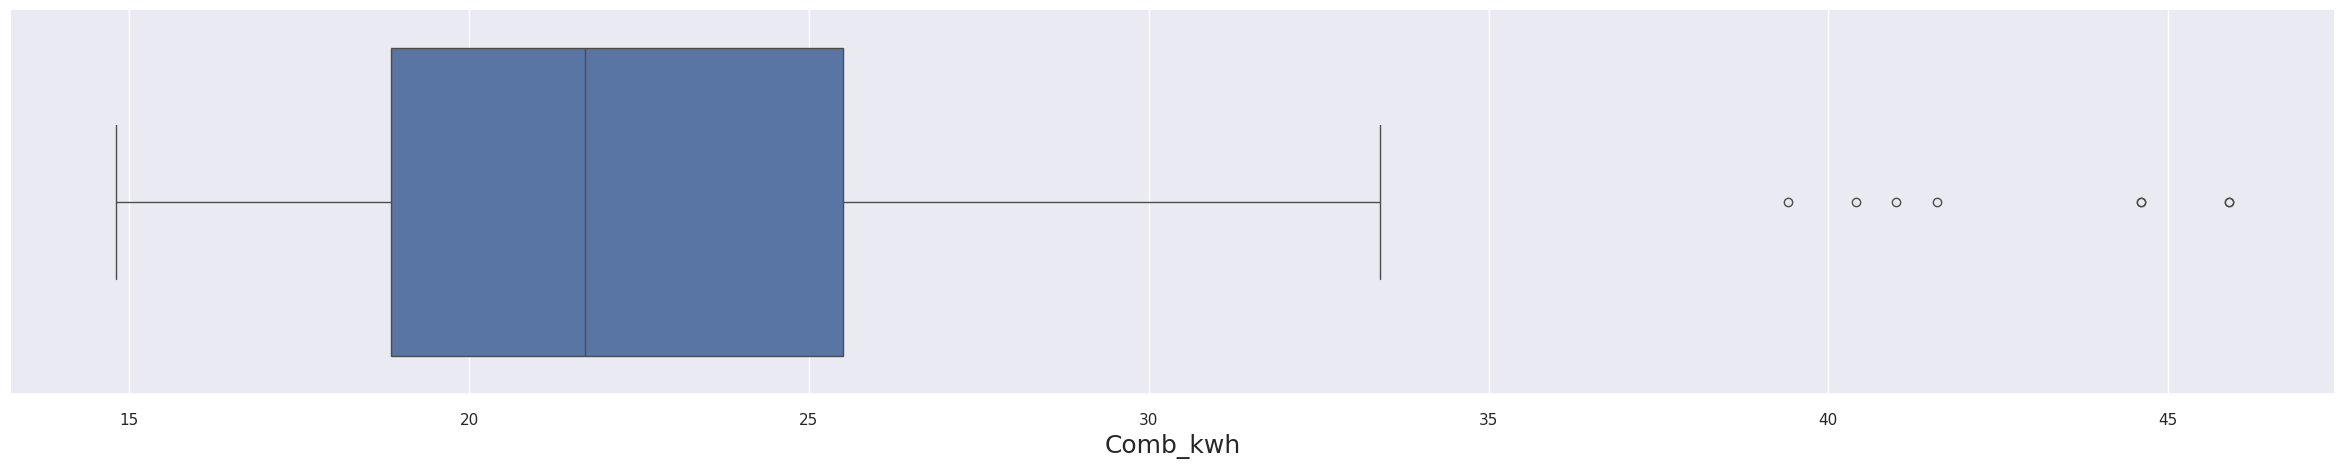

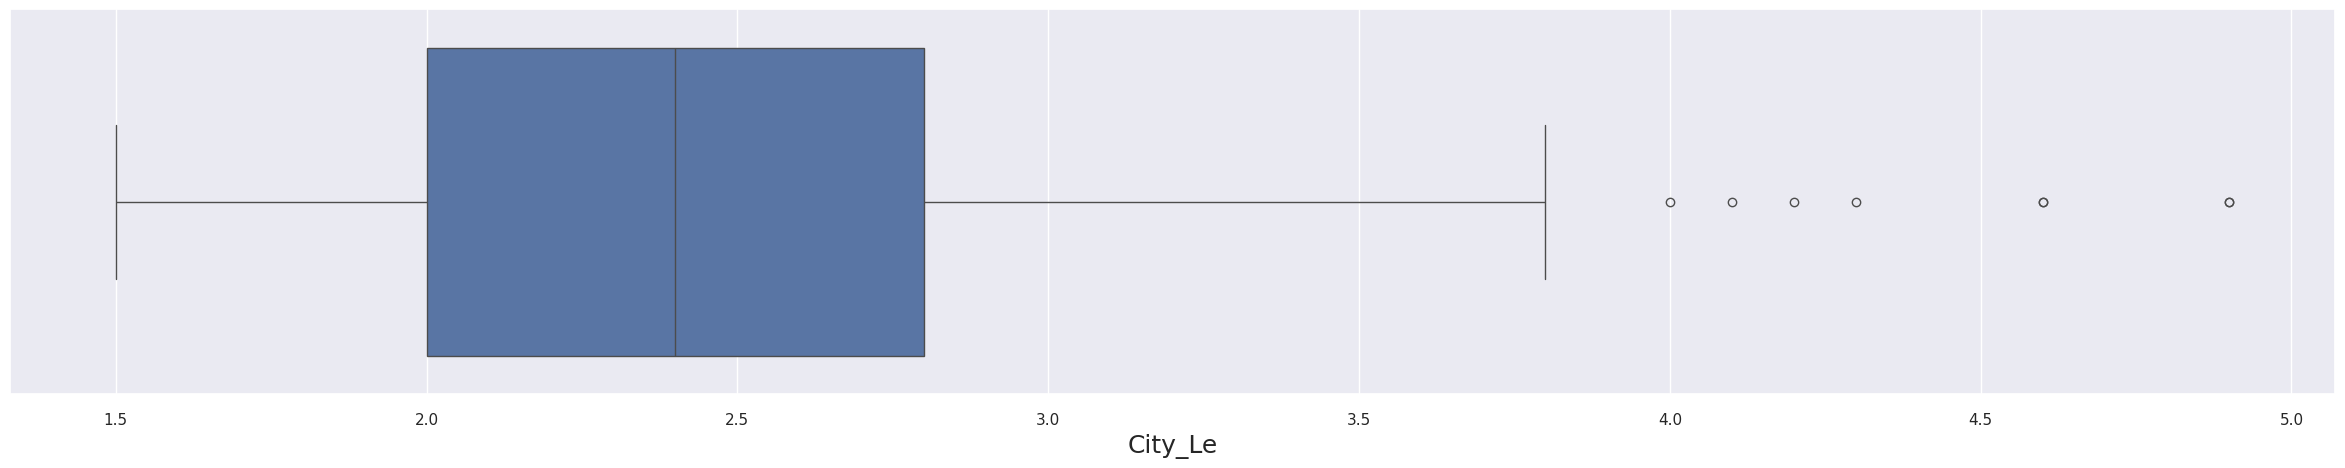

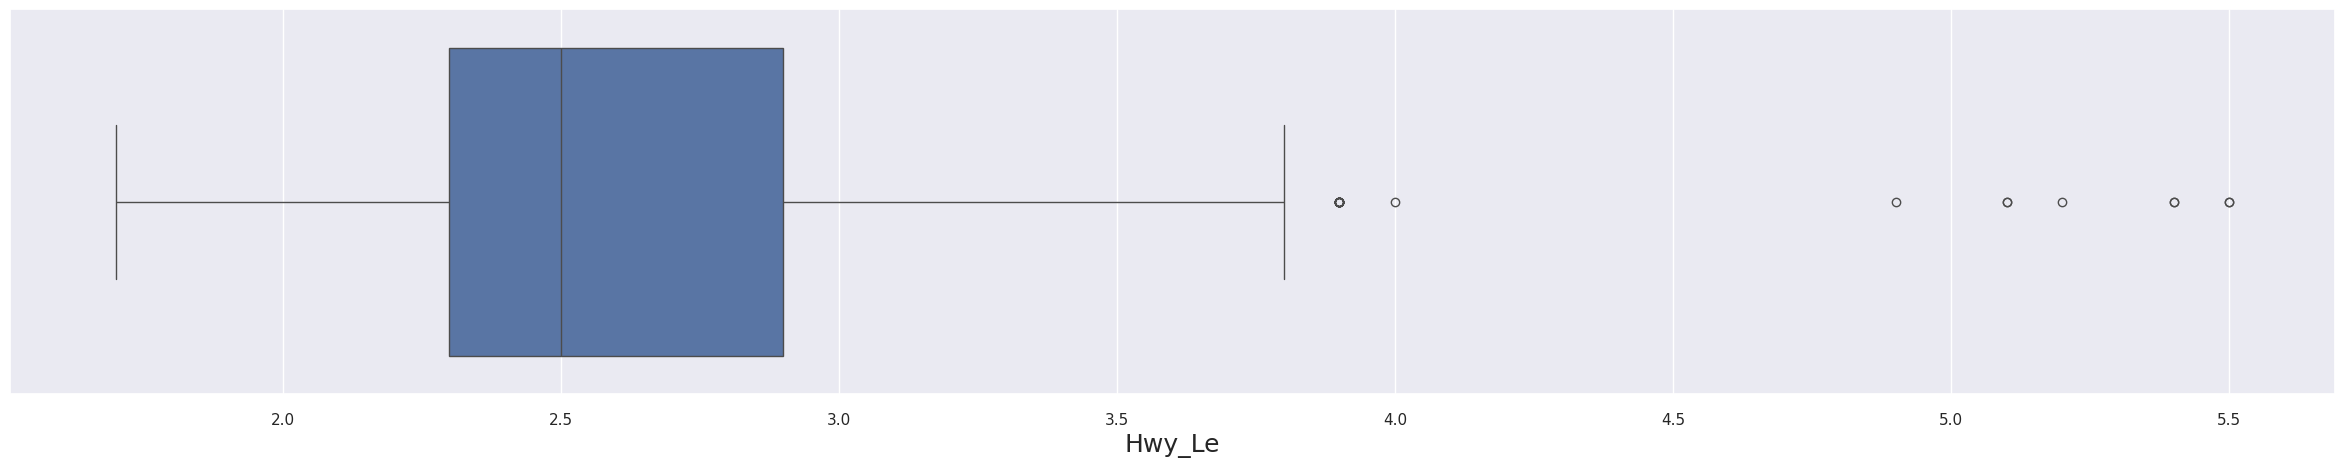

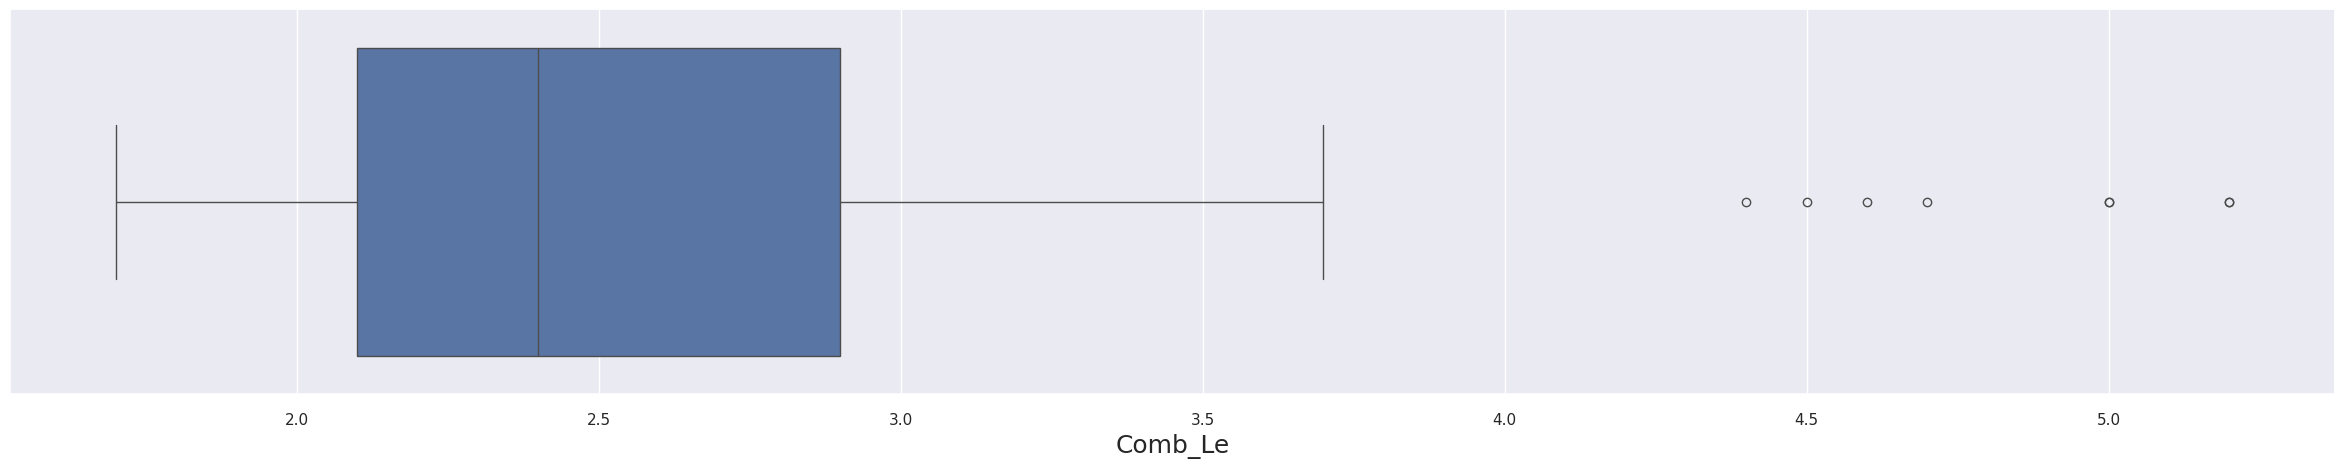

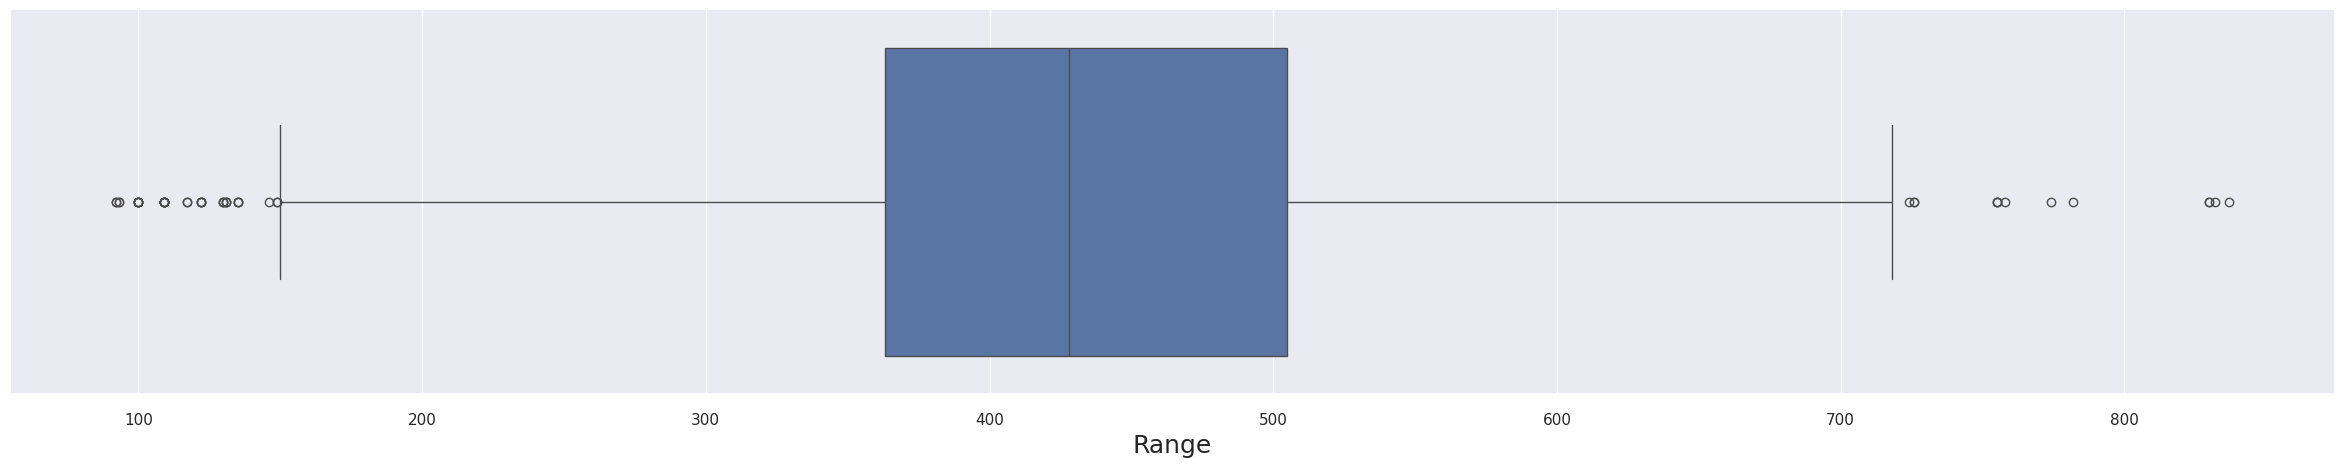

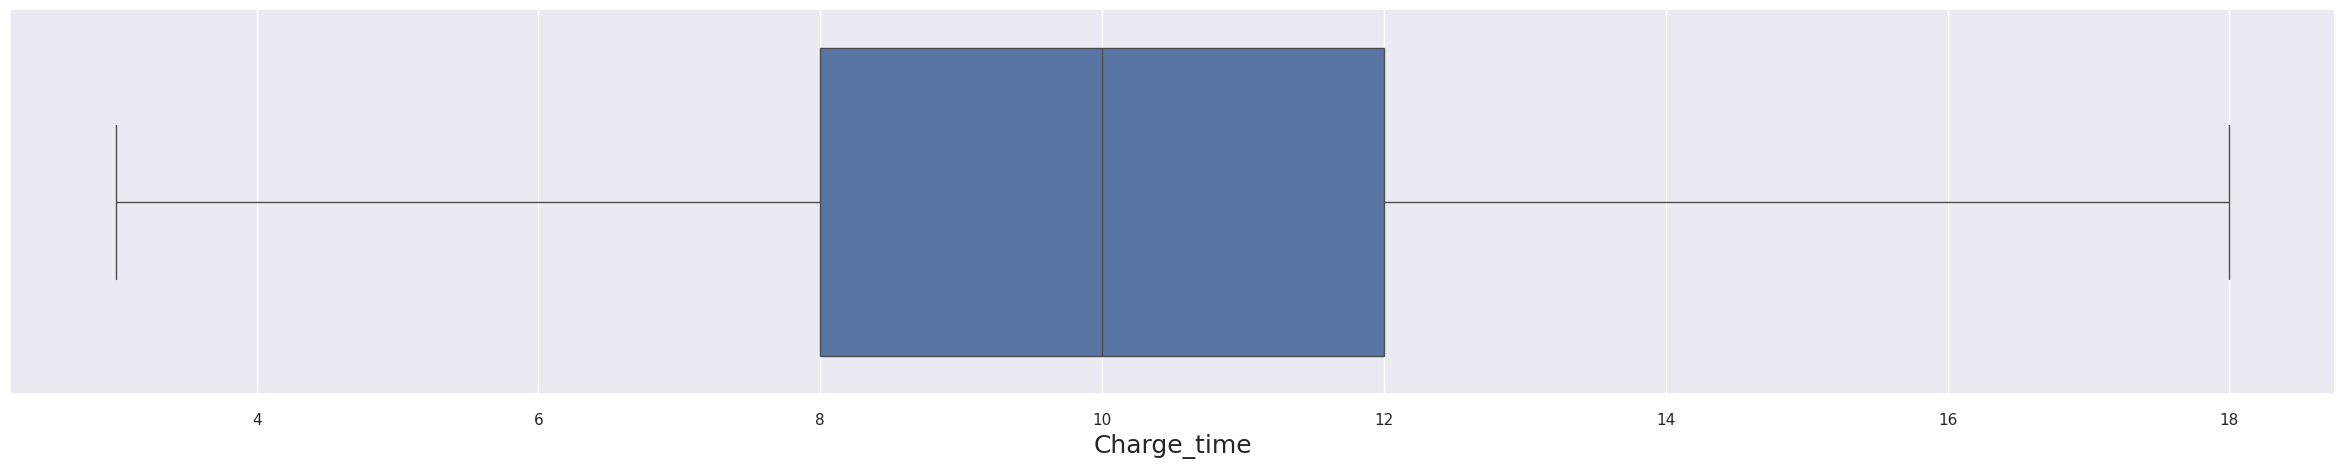

In [ ]:
for column in enumerate(df_num_features):
    plt.figure(figsize=(30,5))
    sns.set_theme(style="darkgrid")
    sns.boxplot(x=column[1], data=  df_num_features)
    plt.xlabel(column[1],fontsize=18)
    plt.show()

### 5.1.2 Removal of Outliers<a id='rem_out'></a>

**Checking the normality of numeric features**

In [ ]:
stat, p_value = shapiro(df_num_features)

print('Test statistic:', stat)
print('P-Value:', p_value)


Test statistic: 0.5038805603981018
P-Value: 0.0


Since the numeric features are not normal we are removing the outliers using IQR method

In [ ]:


#data = data.select_dtypes(include=[np.number])
numeric_cols = data.select_dtypes(include=['number']).columns

data = data[~((data[numeric_cols] < (Q1 - 1.5 * IQR)) |(data[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
data.reset_index(inplace=True, drop=True)

print(data.columns)



Index(['Model year', 'Make', 'Model', 'Vehicle_Class', 'Motor', 'city_kwh',
       'Highway_kwh', 'Comb_kwh', 'City_Le', 'Hwy_Le', 'Comb_Le', 'Range',
       'Charge_time', 'Make_Type', 'Vehicle_Categories'],
      dtype='object')


### 5.1.3 Re-checking Correlation<a id='rec_cor'></a>

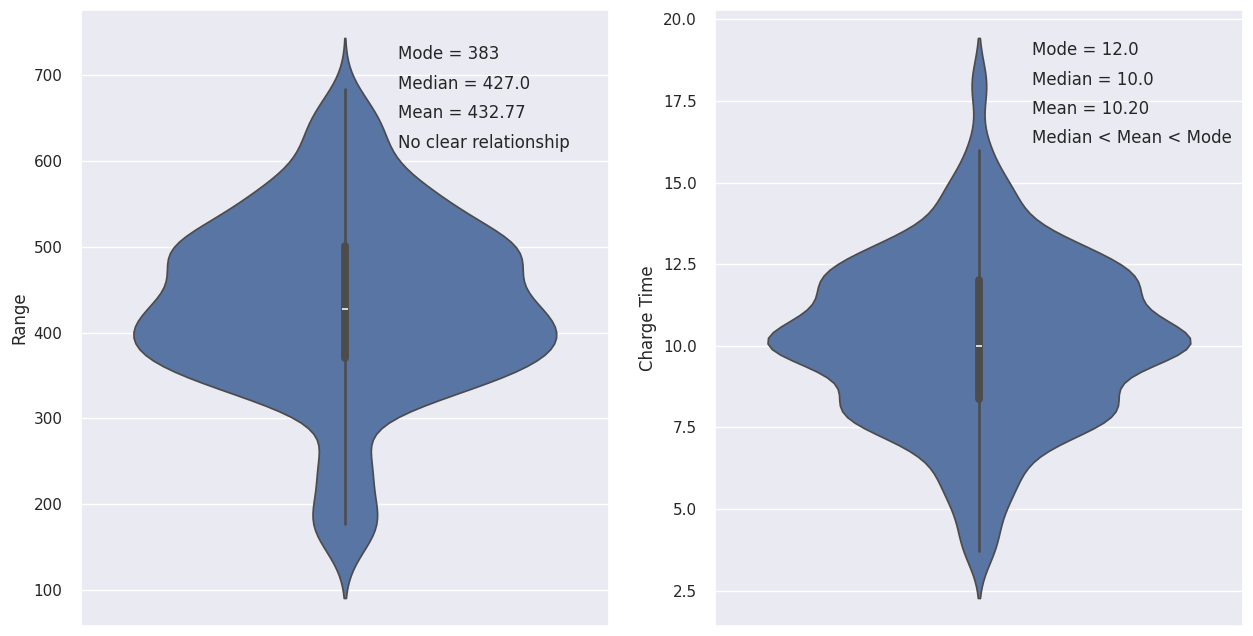

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statistics

# Assuming 'data' is your DataFrame

# Calculate statistics for Range
mode_range = statistics.mode(data['Range'])
median_range = statistics.median(data['Range'])
mean_range = statistics.mean(data['Range'])

# Calculate statistics for Charge Time
mode_charge_time = statistics.mode(data['Charge_time'])
median_charge_time = statistics.median(data['Charge_time'])
mean_charge_time = statistics.mean(data['Charge_time'])

# Determine the relationship between mode, median, and mean for Range
if median_range < mean_range < mode_range:
    relation_range = "Median < Mean < Mode"
elif mode_range < mean_range < median_range:
    relation_range = "Mode < Mean < Median"
elif mean_range < median_range < mode_range:
    relation_range = "Mean < Median < Mode"
else:
    relation_range = "No clear relationship"

# Determine the relationship between mode, median, and mean for Charge Time
if median_charge_time < mean_charge_time < mode_charge_time:
    relation_charge_time = "Median < Mean < Mode"
elif mode_charge_time < mean_charge_time < median_charge_time:
    relation_charge_time = "Mode < Mean < Median"
elif mean_charge_time < median_charge_time < mode_charge_time:
    relation_charge_time = "Mean < Median < Mode"
else:
    relation_charge_time = "No clear relationship"

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plotting Range with its own y-axis
sns.violinplot(y=data['Range'], orient="v", ax=axes[0])
axes[0].set_ylabel('Range')
# Place text annotations higher for Range
axes[0].text(0.1, 1.05 * max(data['Range']), f"Mode = {mode_range}", fontsize=12)
axes[0].text(0.1, 1.00 * max(data['Range']), f"Median = {median_range}", fontsize=12)
axes[0].text(0.1, 0.95 * max(data['Range']), f"Mean = {mean_range:.2f}", fontsize=12)
axes[0].text(0.1, 0.90 * max(data['Range']), relation_range, fontsize=12)

# Creating a secondary y-axis for Charge Time
sns.violinplot(y=data['Charge_time'], orient="v", ax=axes[1])
axes[1].set_ylabel('Charge Time')
# Place text annotations higher for Charge Time
axes[1].text(0.1, 1.05 * max(data['Charge_time']), f"Mode = {mode_charge_time}", fontsize=12)
axes[1].text(0.1, 1.00 * max(data['Charge_time']), f"Median = {median_charge_time}", fontsize=12)
axes[1].text(0.1, 0.95 * max(data['Charge_time']), f"Mean = {mean_charge_time:.2f}", fontsize=12)
axes[1].text(0.1, 0.90 * max(data['Charge_time']), relation_charge_time, fontsize=12)

plt.show()
#print(data.columns)


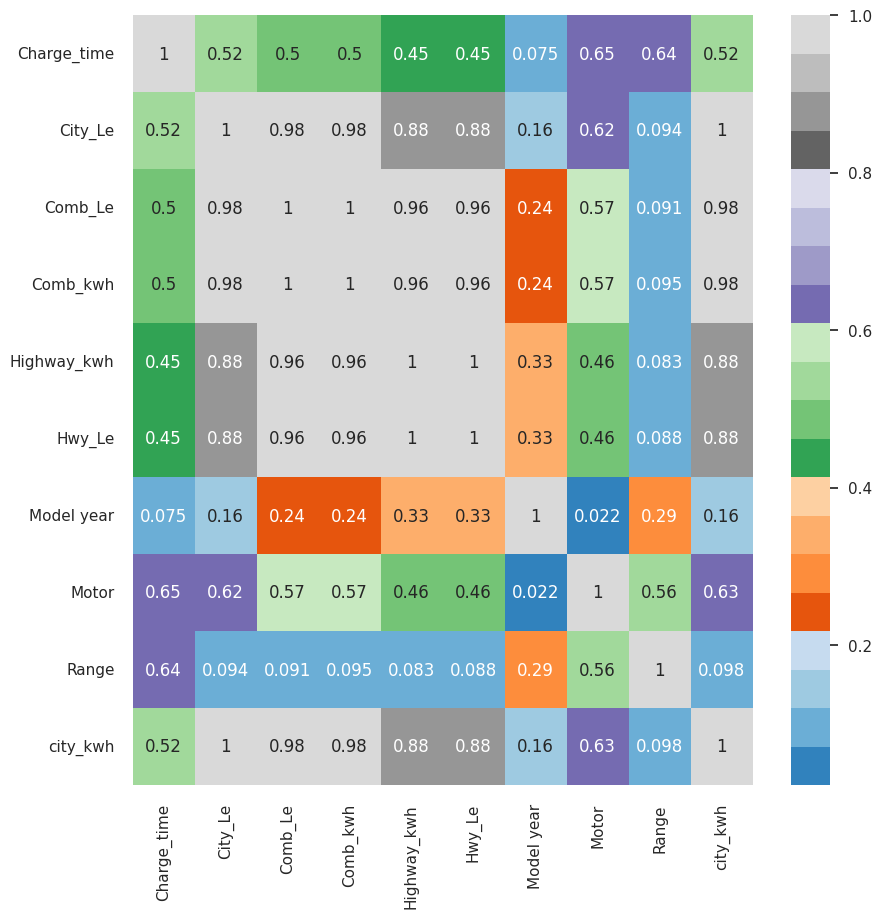

In [ ]:
#features_to_include = data.columns.difference(['_id', 'Combined (mpg)'])

#plt.figure(figsize=(10,10))
#corr = data[features_to_include].corr(method='pearson')
#sns.heatmap(corr, annot=True, cmap='tab20c')
#plt.show()
#print(data.columns)

numeric_cols = data.select_dtypes(include=['number']).columns.difference(['_id', 'Combined (mpg)'])
plt.figure(figsize=(10,10))
corr = data[numeric_cols].corr(method='pearson')
sns.heatmap(corr, annot=True, cmap='tab20c')
plt.show()
#print(data.columns)

There has been a slight change with respect to the correlation between numeric values

In [ ]:
!pip install pycaret

import pycaret
pycaret.__version__

'3.3.2'

In [ ]:
# import pycaret regression and init setup
from pycaret.classification import *
#print(data.columns)
s = setup(data, target = 'Make_Type', session_id = 123)
#Transmission', 'Fuel_Type
print(data.head())

,Description,Value
0,Session id,123
1,Target,Make_Type
2,Target type,Multiclass
3,Target mapping,"General: 0, Luxury: 1, Premium: 2, Sports: 3"
4,Original data shape,"(580, 15)"
5,Transformed data shape,"(580, 25)"
6,Transformed train set shape,"(406, 25)"
7,Transformed test set shape,"(174, 25)"
8,Numeric features,10
9,Categorical features,4


   Model year   Make                Model Vehicle_Class  Motor  city_kwh  \
0        2014  TESLA     Model S (60 kWh)     FULL-SIZE    225 22.200000   
1        2014  TESLA     Model S (85 kWh)     FULL-SIZE    270 23.800000   
2        2014  TESLA  Model S Performance     FULL-SIZE    310 23.900000   
3        2015  TESLA     Model S (60 kWh)     FULL-SIZE    285 22.200000   
4        2015  TESLA     Model S (70 kWh)     FULL-SIZE    285 23.800000   

   Highway_kwh  Comb_kwh  City_Le   Hwy_Le  Comb_Le  Range  Charge_time  \
0    21.700000 21.900000 2.500000 2.400000 2.500000    335    10.000000   
1    23.200000 23.600000 2.700000 2.600000 2.600000    426    12.000000   
2    23.200000 23.600000 2.700000 2.600000 2.600000    426    12.000000   
3    21.700000 21.900000 2.500000 2.400000 2.500000    335    10.000000   
4    23.200000 23.600000 2.700000 2.600000 2.600000    377    12.000000   

  Make_Type Vehicle_Categories  
0    Sports              Sedan  
1    Sports              S

In [ ]:
# @title Default title text
# compare baseline models
best = compare_models()
# create the best performing model based on the comparison



,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:18:22
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# plot confusion matrix
# print model summary
print(best)
#print(data['Make'].value_counts())


plot_model(best, plot = 'confusion_matrix')

In [ ]:
# import pycaret regression and init setup
from pycaret.classification import *
#print(data.columns)
s = setup(data, target = 'Vehicle_Categories', session_id = 123)

In [ ]:
best = compare_models()

plot_model(best, plot = 'confusion_matrix')

In [ ]:
from pycaret.classification import *

# Setup the classification environment
s = setup(data, target='Make', session_id=123)

# Create Ridge Classifier model
ridge_model = create_model('ridge')

# Plot confusion matrix for Ridge Classifier
plot_model(ridge_model, plot='confusion_matrix')

In [ ]:
# import pycaret regression and init setup
from pycaret.regression import *
s = setup(data, target = 'Range', session_id = 123)

In [ ]:
# compare baseline models
best = compare_models()


In [ ]:
# import pycaret regression and init setup
from pycaret.regression import *
s = setup(data, target = 'Charge_time', session_id = 123)

In [ ]:
# compare baseline models
best = compare_models()


In [ ]:
# import pycaret regression and init setup
from pycaret.regression import *
s = setup(data, target = 'Motor', session_id = 123)

In [ ]:
# compare baseline models
best = compare_models()


In [ ]:
# import pycaret regression and init setup
from pycaret.regression import *
s = setup(data, target = 'city_kwh', session_id = 123)

,Description,Value
0,Session id,123
1,Target,city_kwh
2,Target type,Regression
3,Original data shape,"(580, 15)"
4,Transformed data shape,"(580, 28)"
5,Transformed train set shape,"(406, 28)"
6,Transformed test set shape,"(174, 28)"
7,Numeric features,9
8,Categorical features,5
9,Preprocess,True


In [ ]:
best = compare_models()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.1296,0.0320,0.1770,0.9982,0.0082,0.0062,0.8880
br,Bayesian Ridge,0.1308,0.0329,0.1792,0.9981,0.0083,0.0062,0.1790
ridge,Ridge Regression,0.1450,0.0412,0.2004,0.9977,0.0092,0.0069,0.1390
huber,Huber Regressor,0.2282,0.0932,0.3001,0.9947,0.0139,0.0110,0.2400
dt,Decision Tree Regressor,0.3164,0.3534,0.5344,0.9794,0.0244,0.0149,0.1360
et,Extra Trees Regressor,0.4672,0.6873,0.8038,0.9626,0.0322,0.0203,0.8500
ada,AdaBoost Regressor,0.4513,0.6461,0.6720,0.9603,0.0281,0.0202,0.7720
lightgbm,Light Gradient Boosting Machine,0.5297,0.7755,0.8392,0.9574,0.0349,0.0237,0.7020
gbr,Gradient Boosting Regressor,0.5558,0.7902,0.8580,0.9566,0.0364,0.0251,0.8450
en,Elastic Net,0.7067,0.7832,0.8821,0.9565,0.0378,0.0324,0.1390


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
from pycaret.regression import *
s = setup(data, target = 'Highway_kwh', session_id = 123)

,Description,Value
0,Session id,123
1,Target,Highway_kwh
2,Target type,Regression
3,Original data shape,"(580, 15)"
4,Transformed data shape,"(580, 28)"
5,Transformed train set shape,"(406, 28)"
6,Transformed test set shape,"(174, 28)"
7,Numeric features,9
8,Categorical features,5
9,Preprocess,True


In [ ]:
best = compare_models()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.1387,0.0362,0.1888,0.9977,0.0076,0.0059,0.2390
br,Bayesian Ridge,0.1411,0.0381,0.1938,0.9976,0.0078,0.0060,0.1960
ridge,Ridge Regression,0.1798,0.0645,0.2517,0.9960,0.0099,0.0075,0.1390
huber,Huber Regressor,0.3596,0.2254,0.4706,0.9856,0.0191,0.0155,0.2440
ada,AdaBoost Regressor,0.3575,0.2982,0.5260,0.9822,0.0203,0.0150,0.2620
dt,Decision Tree Regressor,0.3205,0.4308,0.5591,0.9697,0.0231,0.0141,0.1410
rf,Random Forest Regressor,0.4891,0.6991,0.7958,0.9588,0.0293,0.0195,0.4070
xgboost,Extreme Gradient Boosting,0.5159,0.8034,0.8628,0.9513,0.0336,0.0212,0.2240
en,Elastic Net,0.6995,0.8102,0.8966,0.9489,0.0362,0.0299,0.1360
llar,Lasso Least Angle Regression,0.7556,0.8913,0.9394,0.9444,0.0377,0.0321,0.1440


Processing:   0%|          | 0/81 [00:00<?, ?it/s]